## Importações e dependências

In [1]:
import os
import glob
import cv2
import numpy as np
import hashlib
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator
from collections import Counter

print("Importações e dependencias feitas com sucesso")

Importações e dependencias feitas com sucesso


## Caminhos

In [3]:
# Diretório onde as imagens do dataset se encontram armazenadas

data_train = '/Users/hugopereira/DatasetMEIA/train'
data_test = '/Users/hugopereira/DatasetMEIA/test'

#data_train = 'C:/Dev/DatasetMEIA/train'
#data_test = 'C:/Dev/DatasetMEIA/test'

if os.path.exists(data_train) and os.path.exists(data_test):
    print("As pastas de dados existem e estão acessíveis.")
else:
    if not os.path.exists(data_train):
        print(f"A pasta de treino '{data_train}' não existe ou não está acessível.")
    if not os.path.exists(data_test):
        print(f"A pasta de teste '{data_test}' não existe ou não está acessível.")

As pastas de dados existem e estão acessíveis.


## Importar Imagens 
Importação de imagens do conjunto teste e treino para efetuar o seu processamento. Ao importar a imagem é tambem guardado o nome a ela associado e é criada uma hash para posteriormente verificar se existem imagens duplicadas.


In [4]:
#Função para calcular uma hash para cada imagem
def calculate_hash(img):
    return hashlib.sha256(img).hexdigest()

# Função para carregar imagens de uma dada pasta
def load_images_from_folder(main_dir):
    images = []
    hashes=[]
    path=[]
    unique_labels=[]
    labels=[]
    for disease_folder in os.listdir(main_dir):
        print(f"A carregar imagens... {disease_folder}")
        folder_path = os.path.join(main_dir, disease_folder)
        if os.path.isdir(folder_path):
            label=disease_folder
            disease_images=[]
            for filename in os.listdir(folder_path):
                try:
                    img = cv2.imread(os.path.join(folder_path, filename),cv2.IMREAD_UNCHANGED)
                    if img is not None:
                        images.append(img)
                        disease_images.append(img)
                        unique_labels.append(label)
                        path.append(filename)
                        hash_imagem=calculate_hash(img)
                        hashes.append(hash_imagem)
                    else:
                        print(f"Não foi possível carregar a imagem: {filename}")
                except Exception as e:
                        print(f"Erro ao carregar a imagem {filename}: {str(e)}")  
            labels.extend([label] * len(disease_images))      
    return images, hashes, path, labels,unique_labels

# Carregar imagens de treino e teste
train_images, train_hashes, train_names, train_labels, train_unique_labels  = load_images_from_folder(data_train)
test_images, test_hashes, test_names, test_labels, test_unique_labels  = load_images_from_folder(data_test)

# Verificar se as imagens foram carregadas corretamente
print(f"Número de imagens de treino carregadas: {len(train_images)}")
print("Numero de labels de treino: ", len(train_labels))
print(f"Número de imagens de teste carregadas: {len(test_images)}")
print("Numero de labels de treino: ", len(test_unique_labels))


A carregar imagens... Urticaria Hives
A carregar imagens... .DS_Store
A carregar imagens... Psoriasis pictures Lichen Planus and related diseases
A carregar imagens... Lupus and other Connective Tissue diseases
A carregar imagens... Atopic Dermatitis Photos
A carregar imagens... Melanoma Skin Cancer Nevi and Moles
A carregar imagens... Urticaria Hives
A carregar imagens... .DS_Store
A carregar imagens... Psoriasis pictures Lichen Planus and related diseases
A carregar imagens... Lupus and other Connective Tissue diseases
A carregar imagens... Atopic Dermatitis Photos
A carregar imagens... Melanoma Skin Cancer Nevi and Moles
Número de imagens de treino carregadas: 2989
Numero de labels de treino:  2989
Número de imagens de teste carregadas: 749
Numero de labels de treino:  749


## Visualização das Imagens

In [5]:
#Função para ver as imagens lado a lado
def see_array_plt(images, images_title=None):
    num_images = len(images)
    if images_title is None:
        images_title = [f"Image {i+1}" for i in range(num_images)]
        
    num_rows = (num_images - 1) // 3 + 1
    plt.figure(figsize=(20, 6 * num_rows))
    for num in range(num_images):
        plt.subplot(num_rows, 3, num + 1)
        plt.axis(False)
        plt.title(f"{images_title[num]}.")
        plt.imshow(images[num]);

Visualização de algumas imagens de treino


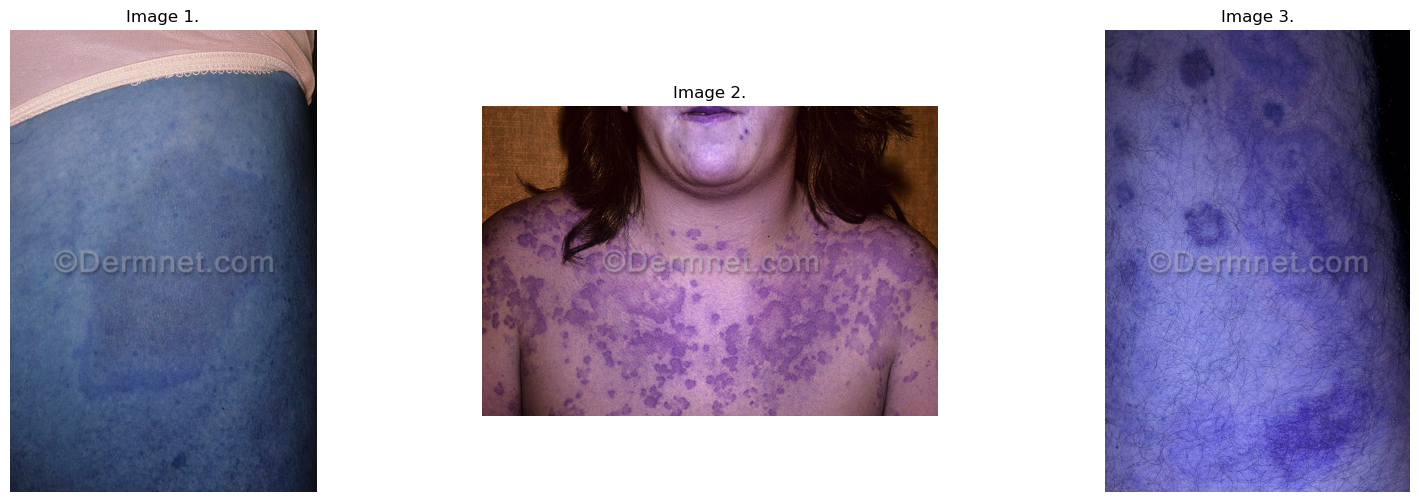

-------------------------------------------------
Visualização de algumas imagens de teste


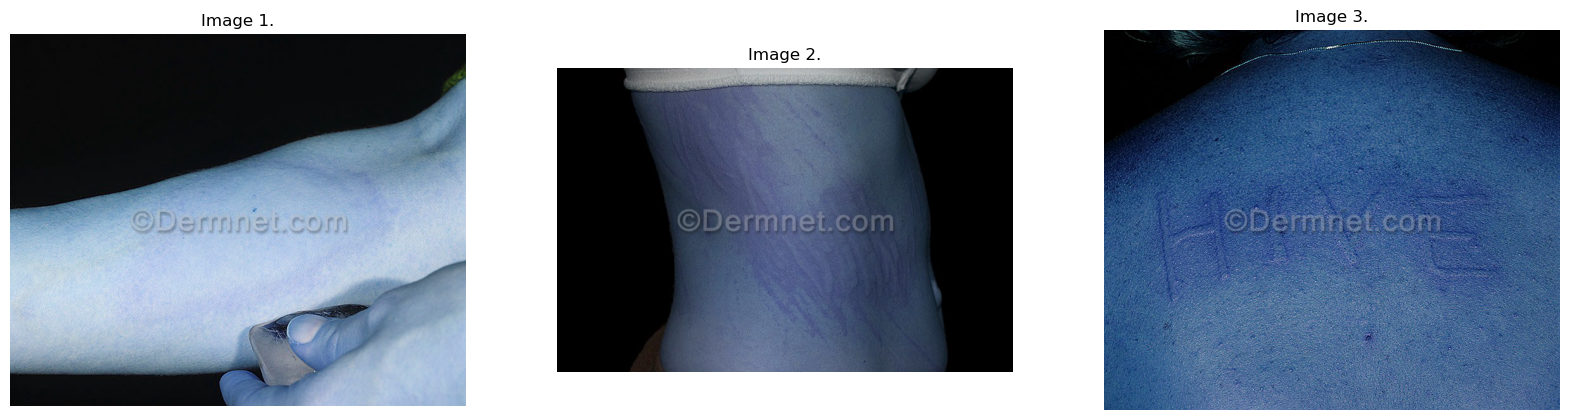

In [7]:
max_images = 3  # Define o número máximo de imagens a serem mostradas
print("Visualização de algumas imagens de treino")
see_array_plt(train_images[:max_images])
plt.show()  # Garante que as imagens de treino sejam exibidas antes do próximo print
print("-------------------------------------------------")
print("Visualização de algumas imagens de teste")
see_array_plt(test_images[:max_images])
plt.show()  # Garante que as imagens de treino sejam exibidas antes do próximo print

# Pré-processamento

# 1.2 Redimensionar Imagens
Para ambos os conjuntos(treino e teste) o tamanho das imagens é ajustado, cortando a imagem caso esta seja maior que o tamanho pretendido(224x224) ou então aumentada atraves de uma borda.

In [8]:
# Redimensionar imagens
def resize_images(images, new_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return resized_images

# Tamanho desejado para as imagens (250x250)
new_size = (250, 250)

# Redimensionar imagens de treino e teste
train_images_resized = resize_images(train_images, new_size)
test_images_resized = resize_images(test_images, new_size)

# Verificar se as imagens foram redimensionadas corretamente
print(f"Número de imagens de treino redimensionadas: {len(train_images_resized)}")
print(f"Número de imagens de teste redimensionadas: {len(test_images_resized)}")

Número de imagens de treino redimensionadas: 2989
Número de imagens de teste redimensionadas: 749


## 1.8 Normalização e Balanceamento dos dados

Para balancear as classes existentes implementamos o Random Over Sampler, este aumenta artificialmente o número de exemplos nas classes minoritárias.

In [9]:
def normalize_images(images):
    normalized_images = []
    for img in images:
        normalized_img = img / 255.0  # Normalizar os valores dos pixels para o intervalo [0, 1]
        normalized_images.append(normalized_img)
    return np.array(normalized_images)

# Normalizar imagens de treinamento e teste
train_images_normalized = normalize_images(train_images_resized)
print(f"Imagens do treino normalizadas concluídas...")

test_images_normalized = normalize_images(test_images_resized)
print(f"Imagens do teste normalizadas concluídas...")

Imagens do treino normalizadas concluídas...
Imagens do teste normalizadas concluídas...


Tamanho X: 7025
Tamanho Y: 7025


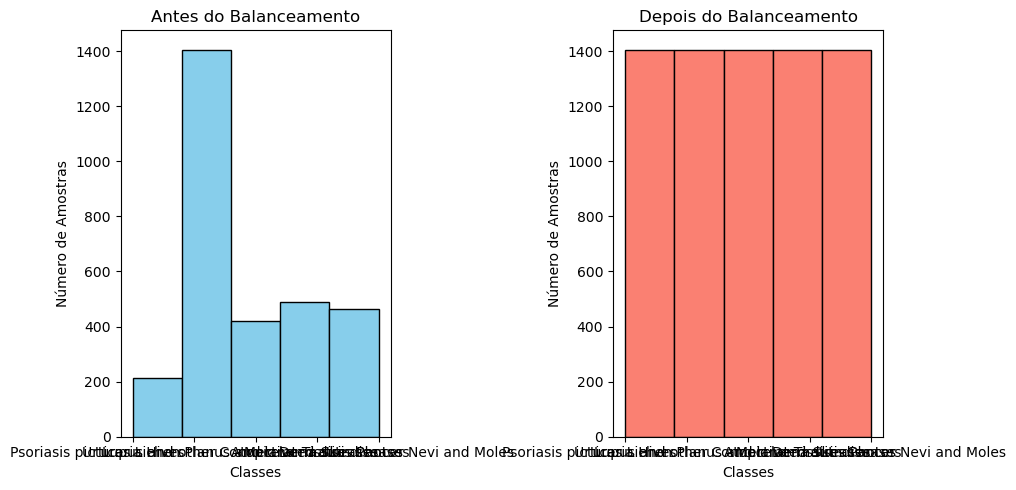

In [10]:
# Seus dados e rótulos
X = train_images_normalized
X_flat = X.reshape(X.shape[0], -1)
y = train_labels

# Gráfico antes do balanceamento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
hist_before = plt.hist(y, bins=len(set(y)), color='skyblue', edgecolor='black')
plt.title('Antes do Balanceamento')
plt.xlabel('Classes')
plt.ylabel('Número de Amostras')
plt.xticks(range(len(set(y))))

# Instanciar o RandomOverSampler
ros = RandomOverSampler(random_state=42)
# Ajustar e transformar os dados
X_resampled, y_resampled = ros.fit_resample(X_flat, y)

restored_images = X_resampled.reshape(-1, 250, 250, 3)

print("Tamanho X:",len(X_resampled))
print("Tamanho Y:", len(y_resampled))

# Gráfico depois do balanceamento
plt.subplot(1, 2, 2)
hist_after = plt.hist(y_resampled, bins=len(set(y)), color='salmon', edgecolor='black')
plt.title('Depois do Balanceamento')
plt.xlabel('Classes')
plt.ylabel('Número de Amostras')
plt.xticks(range(len(set(y))))


plt.tight_layout()
plt.show()


Depois do balanceamento:
Classe: Atopic Dermatitis Photos, Quantidade de amostras: 1405
Classe: Lupus and other Connective Tissue diseases, Quantidade de amostras: 1405
Classe: Melanoma Skin Cancer Nevi and Moles, Quantidade de amostras: 1405
Classe: Psoriasis pictures Lichen Planus and related diseases, Quantidade de amostras: 1405
Classe: Urticaria Hives, Quantidade de amostras: 1405
Visualização de algumas imagens


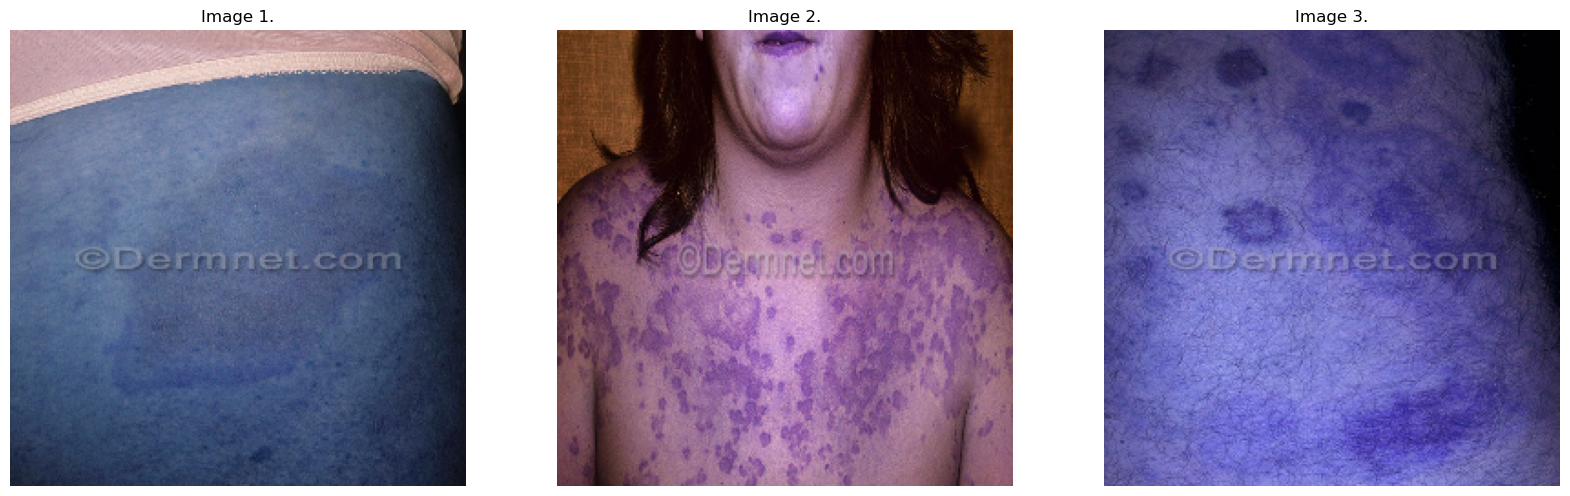

In [11]:
# Encontrar os valores únicos e contagens depois do balanceamento
valores_unicos_after, contagens_after = np.unique(y_resampled, return_counts=True)

# Exibir os resultados depois do balanceamento
print("\nDepois do balanceamento:")
for valor, contagem in zip(valores_unicos_after, contagens_after):
    print(f'Classe: {valor}, Quantidade de amostras: {contagem}')

print("Visualização de algumas imagens")
see_array_plt(restored_images[:3])

# Guardar os novos dados
Após o pre-processamento estar concluido guardar a nova instancia dos dados para posteriormente utiliza-los para treinar diferentes modelos

In [12]:
import shutil
def save_image(i,disease_path,filename):
    img = X[i]
    filename = f'image_{i}.jpg'  # Nome do arquivo
    filepath = os.path.join(disease_path, filename)  # Caminho completo
    # Salvar a imagem
    min_val, max_val = img.min(), img.max()
    img = 255.0 * (img - min_val) / (max_val - min_val)
    img = img.astype(np.uint8)
    cv2.imwrite(filepath, img)
    #print(f"Imagem {filename} salva em: {filepath}")

def save_images_folders(main_folder, X, y):

    # Verifique se o diretório principal existe
    if os.path.exists(main_folder):
        # Se existir, apague-o
        shutil.rmtree(main_folder)
        print(f"Pasta principal em: {main_folder} foi apagada.")

    # Agora crie o diretório
    os.makedirs(main_folder)
    print(f"Pasta principal criada em: {main_folder}")
    
    # Obter classes únicas e seus índices
    classes = np.unique(y)
    print("Classes unicas:",classes)
    
    # Iterar sobre as classes
    for disease in classes:
        # Criar um diretório para cada classe
        disease_path = os.path.join(main_folder, str(disease)) 
        os.makedirs(disease_path, exist_ok=True)
        print(f"Pasta da classe {disease} criada em: {disease_path}")
        
        # Salvar cada imagem nesta classe em sua respectiva pasta
        for i, label in enumerate(y):
            if label == disease:
                print(f"A guardar imagens de {disease}....")
                save_image(i,disease,disease_path)
        else:
            print(f"Nenhuma instância encontrada para a classe {classe}.")
        
    print("Salvo em pastas com sucesso!")

# Exemplo de uso:
train_folder = 'DataProcessedLabels/train'
save_images_folders(train_folder, restored_images, y_resampled)
print("Dados de treino salvos com sucesso")


test_folder='DataProcessedLabels/test'
save_images_folders(test_folder, test_images_resized, test_labels)
print("Dados de teste salvos com sucesso")

Pasta principal criada em: DataProcessedLabels/train
Classes unicas: ['Atopic Dermatitis Photos' 'Lupus and other Connective Tissue diseases'
 'Melanoma Skin Cancer Nevi and Moles'
 'Psoriasis pictures Lichen Planus and related diseases' 'Urticaria Hives']
Pasta da classe Atopic Dermatitis Photos criada em: DataProcessedLabels/train/Atopic Dermatitis Photos
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis Photos....
A guardar imagens de Atopic Dermatitis P

IndexError: index 2989 is out of bounds for axis 0 with size 2989